In [1]:
import os, glob, time, datetime
import numpy as np
from PIL import Image
import imageio
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import torch.nn as nn
from torchvision.utils import save_image

from common.dataset import TrainDataProvider, save_fixed_sample
from common.function import init_embedding
from common.models import Encoder, Decoder, Discriminator, Generator
from common.utils import denorm_image
from common.utils import centering_image
from common.train import Trainer

## Freeze : Encoder만 얼린다

## Transfer Learning
- 150epoch 가 pre-trained 된 모델을 이용해서 손글씨를 적은 데이터로 학습시킨다

In [2]:
GPU = torch.cuda.is_available()
GPU

True

In [3]:
user_name = 'jeina'
root_path = './handwritings/%s' % user_name

data_dir = os.path.join(root_path, '%s_dataset/' % user_name)
fixed_dir = os.path.join(root_path, '%s_fixed_sample' % user_name)
fixed_id = 0
fonts_num = 25
batch_size = 10
img_size = 128

In [4]:
trainer = Trainer(GPU, data_dir, fixed_dir, fonts_num, batch_size, img_size)

unpickled total 210 examples
unpickled total 0 examples
train examples -> 210, val examples -> 0
total batches: 21


### Ground Truth Target

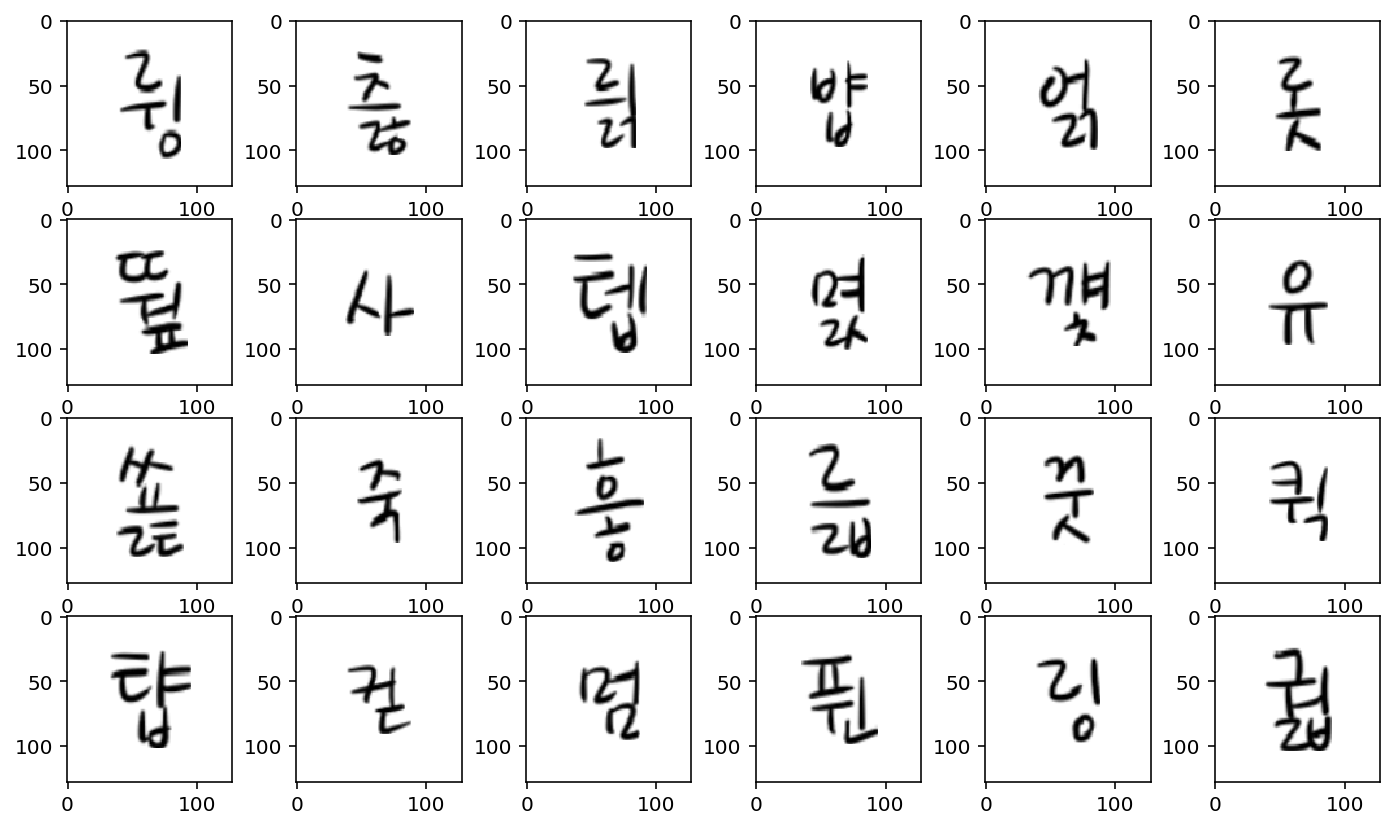

In [5]:
fixed_target = torch.load(os.path.join(fixed_dir, 'fixed_target.pkl'))

plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_target):
    plt.subplot(4, 6, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().numpy(), cmap='gray')
plt.show()

---

### freeze_encoder=True 로 두고 Transfer Learning!
- loss가 안 튀는 곳까지만 학습시키기

### 190 ~ 220epoch

In [16]:
save_path = os.path.join(root_path, '%s_fixed_fake/' % user_name)
to_model_path = os.path.join(root_path, '%s_model_checkpoint/' % user_name)
if not os.path.exists(save_path):
    os.mkdir(save_path)
if not os.path.exists(to_model_path):
    os.mkdir(to_model_path)
    
from_model_path = './model_checkpoint/new_training'
restore = ['190-0611-09:14-Encoder.pkl', '190-0611-09:14-Decoder.pkl', '190-0611-09:14-Discriminator.pkl']

max_epoch = 30
schedule = 10
lr = 0.001
log_step = 20
sample_step = 20

losses = trainer.train(max_epoch=max_epoch, schedule=schedule, save_path=save_path, \
                       lr=lr, log_step=log_step, sample_step=sample_step, restore=restore, \
                       to_model_path=to_model_path, from_model_path=from_model_path, \
                       with_charid=True, freeze_encoder=True, save_nrow=6, resize_fix=1.3)

190 epoch trained model has restored
13:33:36 Epoch [191/220], step [20/21], l1_loss: 21.3031, d_loss: 0.0060, g_loss: 34.8842
13:33:42 Epoch [192/220], step [20/21], l1_loss: 23.0609, d_loss: 0.0082, g_loss: 32.7534
13:33:48 Epoch [193/220], step [20/21], l1_loss: 19.9216, d_loss: 0.0005, g_loss: 35.1935
13:33:54 Epoch [194/220], step [20/21], l1_loss: 17.5355, d_loss: 0.0132, g_loss: 30.5690
13:33:59 Epoch [195/220], step [20/21], l1_loss: 16.5392, d_loss: 0.0023, g_loss: 29.0742
13:34:05 Epoch [196/220], step [20/21], l1_loss: 15.8765, d_loss: 0.0003, g_loss: 25.1733
13:34:11 Epoch [197/220], step [20/21], l1_loss: 17.1527, d_loss: 0.0000, g_loss: 29.8546
13:34:17 Epoch [198/220], step [20/21], l1_loss: 13.1319, d_loss: 0.0001, g_loss: 23.2530
13:34:23 Epoch [199/220], step [20/21], l1_loss: 15.1038, d_loss: 0.0004, g_loss: 24.0042
decay learning rate from 0.00100 to 0.00050
13:34:29 Epoch [200/220], step [20/21], l1_loss: 15.9940, d_loss: 0.0009, g_loss: 23.9393
13:34:35 Epoch [201

### losses

In [17]:
l1_losses, const_losses, category_losses, d_losses, g_losses = losses

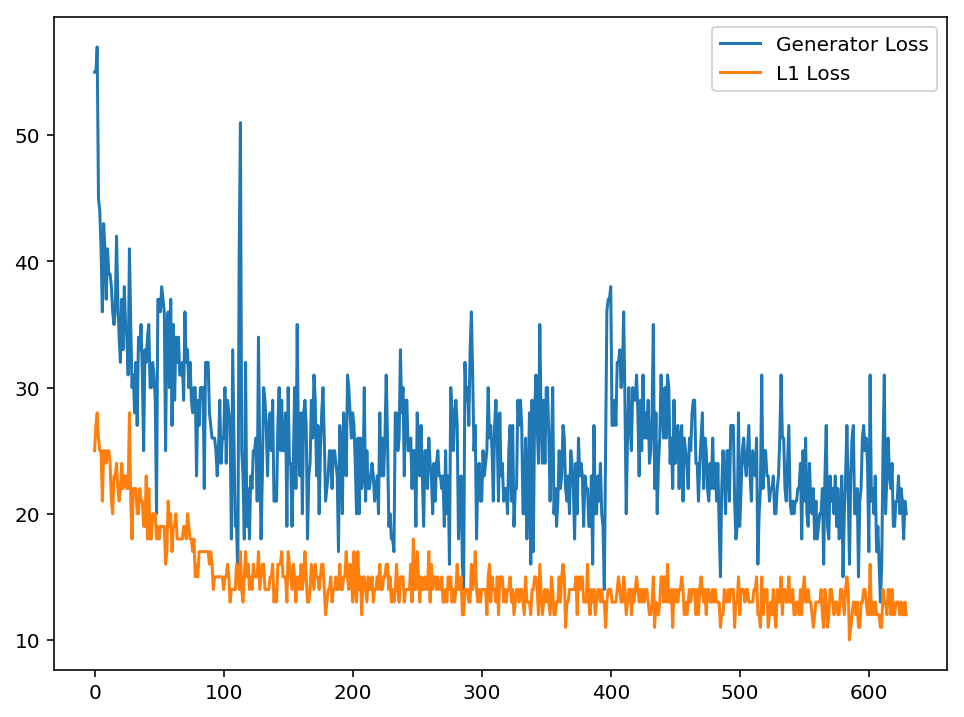

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(g_losses, label='Generator Loss')
plt.plot(l1_losses, label='L1 Loss')
plt.legend()
plt.show()

In [19]:
print('initial loss:', np.mean(g_losses[:100]), '->', 'last loss:', np.mean(g_losses[-100:]))

initial loss: 33.09 -> last loss: 21.66


### Fine Tune - 220~340epoch

In [20]:
save_path = os.path.join(root_path, '%s_fixed_fake/' % user_name)
to_model_path = os.path.join(root_path, '%s_model_checkpoint/' % user_name)
from_model_path = os.path.join(root_path, '%s_model_checkpoint/' % user_name)
restore = ['220-0611-13:36-Encoder.pkl', '220-0611-13:36-Decoder.pkl', '220-0611-13:36-Discriminator.pkl']

max_epoch = 120
schedule = 40
lr = 0.001
log_step = 20
sample_step = 20

losses = trainer.train(max_epoch=max_epoch, schedule=schedule, save_path=save_path, \
                       lr=lr, log_step=log_step, sample_step=sample_step, restore=restore, \
                       to_model_path=to_model_path, from_model_path=from_model_path, \
                       with_charid=True, freeze_encoder=True, fine_tune=True, \
                       save_nrow=6, model_save_step=30)

220 epoch trained model has restored
13:38:15 Epoch [221/340], step [20/21], l1_loss: 62.4394, d_loss: 0.0070, g_loss: 75.3684
13:38:21 Epoch [222/340], step [20/21], l1_loss: 58.9681, d_loss: 0.0007, g_loss: 67.5406
13:38:26 Epoch [223/340], step [20/21], l1_loss: 52.7499, d_loss: 0.0002, g_loss: 62.4482
13:38:32 Epoch [224/340], step [20/21], l1_loss: 56.4812, d_loss: 0.0000, g_loss: 70.0181
13:38:38 Epoch [225/340], step [20/21], l1_loss: 62.7569, d_loss: 0.0003, g_loss: 75.8230
13:38:44 Epoch [226/340], step [20/21], l1_loss: 54.6729, d_loss: 0.0000, g_loss: 68.1658
13:38:49 Epoch [227/340], step [20/21], l1_loss: 66.0828, d_loss: 0.0001, g_loss: 77.1480
13:38:55 Epoch [228/340], step [20/21], l1_loss: 65.9859, d_loss: 0.0010, g_loss: 74.2433
13:39:01 Epoch [229/340], step [20/21], l1_loss: 59.2928, d_loss: 0.0001, g_loss: 80.8397
13:39:07 Epoch [230/340], step [20/21], l1_loss: 55.6859, d_loss: 0.0001, g_loss: 67.2013
13:39:12 Epoch [231/340], step [20/21], l1_loss: 58.6715, d_los

13:46:53 Epoch [311/340], step [20/21], l1_loss: 55.1680, d_loss: 0.0012, g_loss: 66.7895
13:46:59 Epoch [312/340], step [20/21], l1_loss: 56.8563, d_loss: 0.0160, g_loss: 66.4584
13:47:05 Epoch [313/340], step [20/21], l1_loss: 58.4983, d_loss: 0.0019, g_loss: 67.8258
13:47:11 Epoch [314/340], step [20/21], l1_loss: 53.3992, d_loss: 0.0046, g_loss: 62.8398
13:47:16 Epoch [315/340], step [20/21], l1_loss: 58.8810, d_loss: 0.0038, g_loss: 72.4551
13:47:22 Epoch [316/340], step [20/21], l1_loss: 56.7807, d_loss: 0.0015, g_loss: 66.7249
13:47:28 Epoch [317/340], step [20/21], l1_loss: 54.3445, d_loss: 0.0572, g_loss: 63.8642
13:47:33 Epoch [318/340], step [20/21], l1_loss: 57.5572, d_loss: 0.0011, g_loss: 70.1156
13:47:39 Epoch [319/340], step [20/21], l1_loss: 65.3191, d_loss: 0.0088, g_loss: 74.0353
13:47:45 Epoch [320/340], step [20/21], l1_loss: 66.1436, d_loss: 0.0188, g_loss: 72.6422
13:47:51 Epoch [321/340], step [20/21], l1_loss: 66.7471, d_loss: 0.1163, g_loss: 73.2277
13:47:56 E

- 1epoch에 3초 : 100epoch에 300초, 5분

In [21]:
l1_losses, const_losses, category_losses, d_losses, g_losses = losses

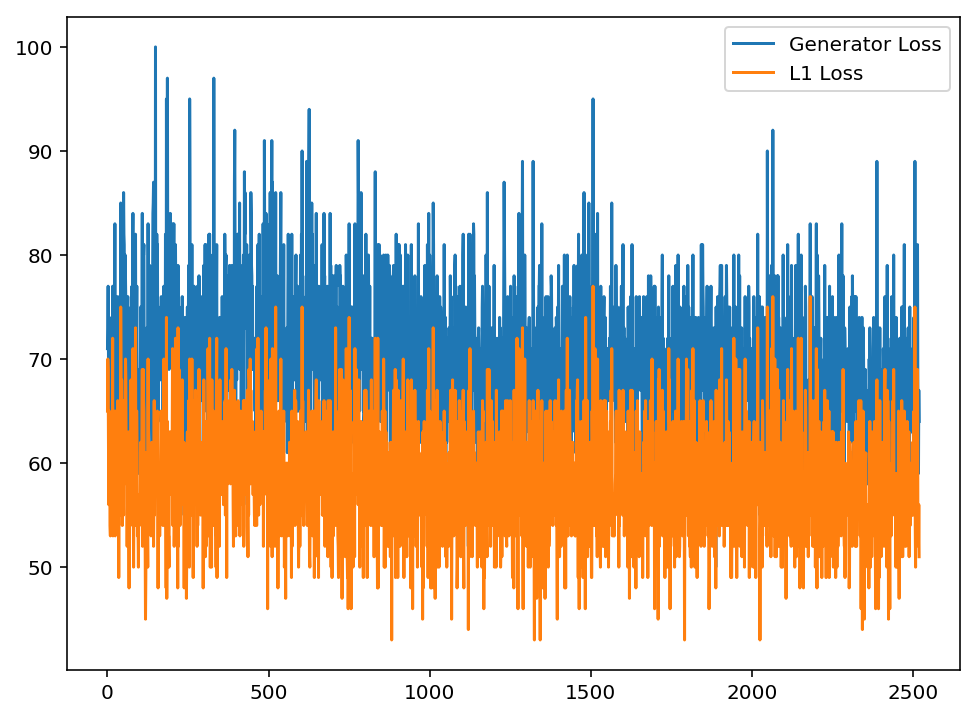

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(g_losses, label='Generator Loss')
plt.plot(l1_losses, label='L1 Loss')
plt.legend()
plt.show()

In [23]:
print('initial loss:', np.mean(g_losses[:500]), '->', 'last loss:', np.mean(g_losses[-500:]))

initial loss: 71.278 -> last loss: 67.604


### 340~540 epoch train
- 100epoch에 5분, 200epoch에 10분

In [25]:
save_path = os.path.join(root_path, '%s_fixed_fake/' % user_name)
to_model_path = os.path.join(root_path, '%s_model_checkpoint/' % user_name)
from_model_path = os.path.join(root_path, '%s_model_checkpoint/' % user_name)
restore = ['340-0611-13:49-Encoder.pkl', '340-0611-13:49-Decoder.pkl', '340-0611-13:49-Discriminator.pkl']

max_epoch = 200
schedule = 40
lr = 0.0002
log_step = 20
sample_step = 20

losses = trainer.train(max_epoch=max_epoch, schedule=schedule, save_path=save_path, \
                       lr=lr, log_step=log_step, sample_step=sample_step, restore=restore, \
                       to_model_path=to_model_path, from_model_path=from_model_path, \
                       with_charid=True, freeze_encoder=True, fine_tune=True, \
                       save_nrow=6, model_save_step=30, flip_labels=True)

340 epoch trained model has restored
13:54:20 Epoch [341/540], step [20/21], l1_loss: 67.3142, d_loss: 0.0001, g_loss: 78.6857
13:54:26 Epoch [342/540], step [20/21], l1_loss: 59.0687, d_loss: 0.0002, g_loss: 72.8325
13:54:32 Epoch [343/540], step [20/21], l1_loss: 54.2859, d_loss: 0.0533, g_loss: 61.1853
13:54:38 Epoch [344/540], step [20/21], l1_loss: 59.7943, d_loss: 0.0015, g_loss: 72.8679
13:54:43 Epoch [345/540], step [20/21], l1_loss: 60.6075, d_loss: 0.0082, g_loss: 69.9451
13:54:49 Epoch [346/540], step [20/21], l1_loss: 66.3083, d_loss: 0.0353, g_loss: 83.4313
13:54:55 Epoch [347/540], step [20/21], l1_loss: 55.8129, d_loss: 0.0744, g_loss: 64.0999
13:55:00 Epoch [348/540], step [20/21], l1_loss: 53.2954, d_loss: 0.0000, g_loss: 70.0173
13:55:06 Epoch [349/540], step [20/21], l1_loss: 74.9614, d_loss: 0.0249, g_loss: 83.5387
13:55:12 Epoch [350/540], step [20/21], l1_loss: 58.2581, d_loss: 0.0004, g_loss: 69.4808
13:55:18 Epoch [351/540], step [20/21], l1_loss: 55.8301, d_los

14:03:03 Epoch [432/540], step [20/21], l1_loss: 62.0578, d_loss: 0.4199, g_loss: 70.3302
14:03:09 Epoch [433/540], step [20/21], l1_loss: 53.6382, d_loss: 0.0017, g_loss: 62.5527
14:03:15 Epoch [434/540], step [20/21], l1_loss: 53.9373, d_loss: 0.0150, g_loss: 60.3870
14:03:21 Epoch [435/540], step [20/21], l1_loss: 53.3911, d_loss: 0.0089, g_loss: 62.7204
14:03:26 Epoch [436/540], step [20/21], l1_loss: 55.5413, d_loss: 0.0075, g_loss: 63.6446
14:03:32 Epoch [437/540], step [20/21], l1_loss: 60.3582, d_loss: 0.0070, g_loss: 72.6102
14:03:38 Epoch [438/540], step [20/21], l1_loss: 61.0020, d_loss: 0.2071, g_loss: 65.0643
14:03:43 Epoch [439/540], step [20/21], l1_loss: 49.2171, d_loss: 0.0046, g_loss: 59.0538
14:03:49 Epoch [440/540], step [20/21], l1_loss: 63.3076, d_loss: 0.0005, g_loss: 76.2292
14:03:55 Epoch [441/540], step [20/21], l1_loss: 62.9870, d_loss: 0.0153, g_loss: 71.1161
14:04:01 Epoch [442/540], step [20/21], l1_loss: 54.4606, d_loss: 0.0033, g_loss: 67.5881
14:04:06 E

14:11:54 Epoch [524/540], step [20/21], l1_loss: 52.9766, d_loss: 0.0013, g_loss: 65.6656
14:12:00 Epoch [525/540], step [20/21], l1_loss: 51.7476, d_loss: 0.0023, g_loss: 63.0652
14:12:05 Epoch [526/540], step [20/21], l1_loss: 62.4746, d_loss: 0.0506, g_loss: 66.3353
14:12:11 Epoch [527/540], step [20/21], l1_loss: 62.6965, d_loss: 0.0014, g_loss: 70.9588
14:12:17 Epoch [528/540], step [20/21], l1_loss: 49.2070, d_loss: 0.0020, g_loss: 57.3693
14:12:22 Epoch [529/540], step [20/21], l1_loss: 52.8834, d_loss: 0.0026, g_loss: 61.2533
14:12:28 Epoch [530/540], step [20/21], l1_loss: 62.7238, d_loss: 0.0012, g_loss: 70.4757
14:12:34 Epoch [531/540], step [20/21], l1_loss: 59.8582, d_loss: 0.0016, g_loss: 72.4493
14:12:40 Epoch [532/540], step [20/21], l1_loss: 58.2781, d_loss: 0.0318, g_loss: 63.4401
14:12:45 Epoch [533/540], step [20/21], l1_loss: 50.3010, d_loss: 0.0161, g_loss: 60.4367
14:12:51 Epoch [534/540], step [20/21], l1_loss: 51.8899, d_loss: 0.0089, g_loss: 63.7283
14:12:57 E

In [26]:
l1_losses, const_losses, category_losses, d_losses, g_losses = losses

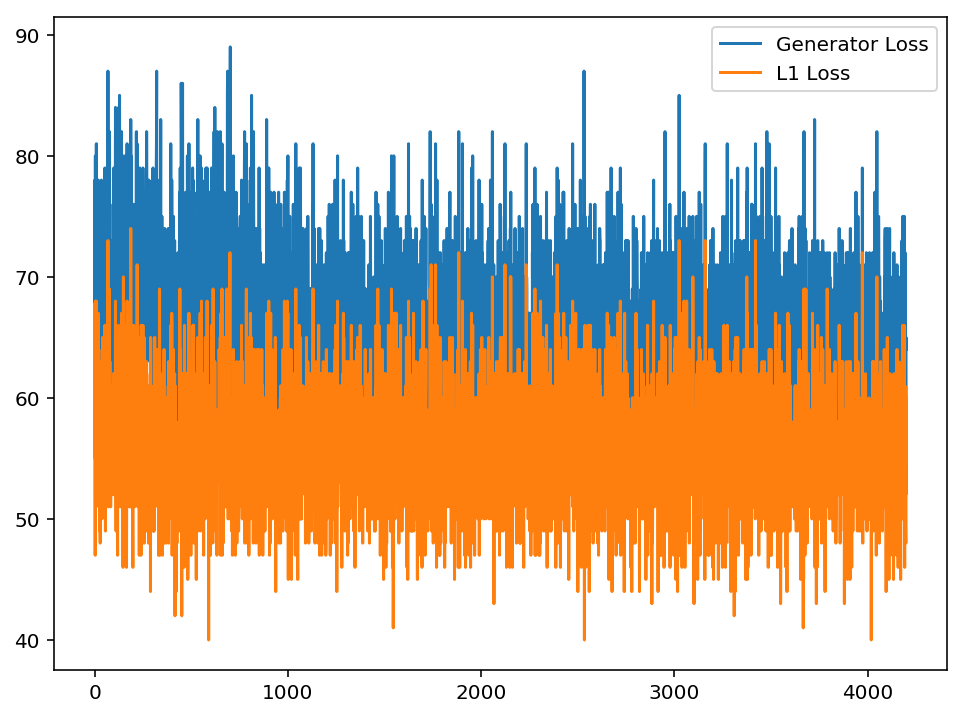

In [27]:
plt.figure(figsize=(8, 6))
plt.plot(g_losses, label='Generator Loss')
plt.plot(l1_losses, label='L1 Loss')
plt.legend()
plt.show()

In [28]:
print('initial loss:', np.mean(g_losses[:500]), '->', 'last loss:', np.mean(g_losses[-500:]))

initial loss: 68.232 -> last loss: 63.704


- 계속 loss가 내려가네.. 더 학습시켜야겠는데

---

### save GIF

In [53]:
image_path = os.path.join(root_path, '%s_fixed_fake/' % user_name)
filenames = sorted(glob.glob(os.path.join(image_path, "*.png")))[1:]
filenames = [filenames[idx] for idx in range(50) if (idx % 3) == 0] + \
            [filenames[idx] for idx in range(51, 300) if (idx % 20) == 0] + \
            [filenames[idx] for idx in range(301, len(filenames)) if ((idx+1) % 20) == 0]
print(len(filenames))
filenames[:10]

31


['./handwritings/jeina/jeina_fixed_fake/fake_samples-191-20.png',
 './handwritings/jeina/jeina_fixed_fake/fake_samples-194-20.png',
 './handwritings/jeina/jeina_fixed_fake/fake_samples-197-20.png',
 './handwritings/jeina/jeina_fixed_fake/fake_samples-200-20.png',
 './handwritings/jeina/jeina_fixed_fake/fake_samples-203-20.png',
 './handwritings/jeina/jeina_fixed_fake/fake_samples-206-20.png',
 './handwritings/jeina/jeina_fixed_fake/fake_samples-209-20.png',
 './handwritings/jeina/jeina_fixed_fake/fake_samples-212-20.png',
 './handwritings/jeina/jeina_fixed_fake/fake_samples-215-20.png',
 './handwritings/jeina/jeina_fixed_fake/fake_samples-218-20.png']

In [54]:
gif_path = os.path.join(root_path, '%s_gifz' % user_name)
if not os.path.exists(gif_path):
    os.mkdir(gif_path)
image_path = os.path.join(root_path, '%s_fixed_fake/' % user_name)
file_name = '%s_training.gif' % user_name

images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave(os.path.join(gif_path, file_name), images)

### 최종 결과

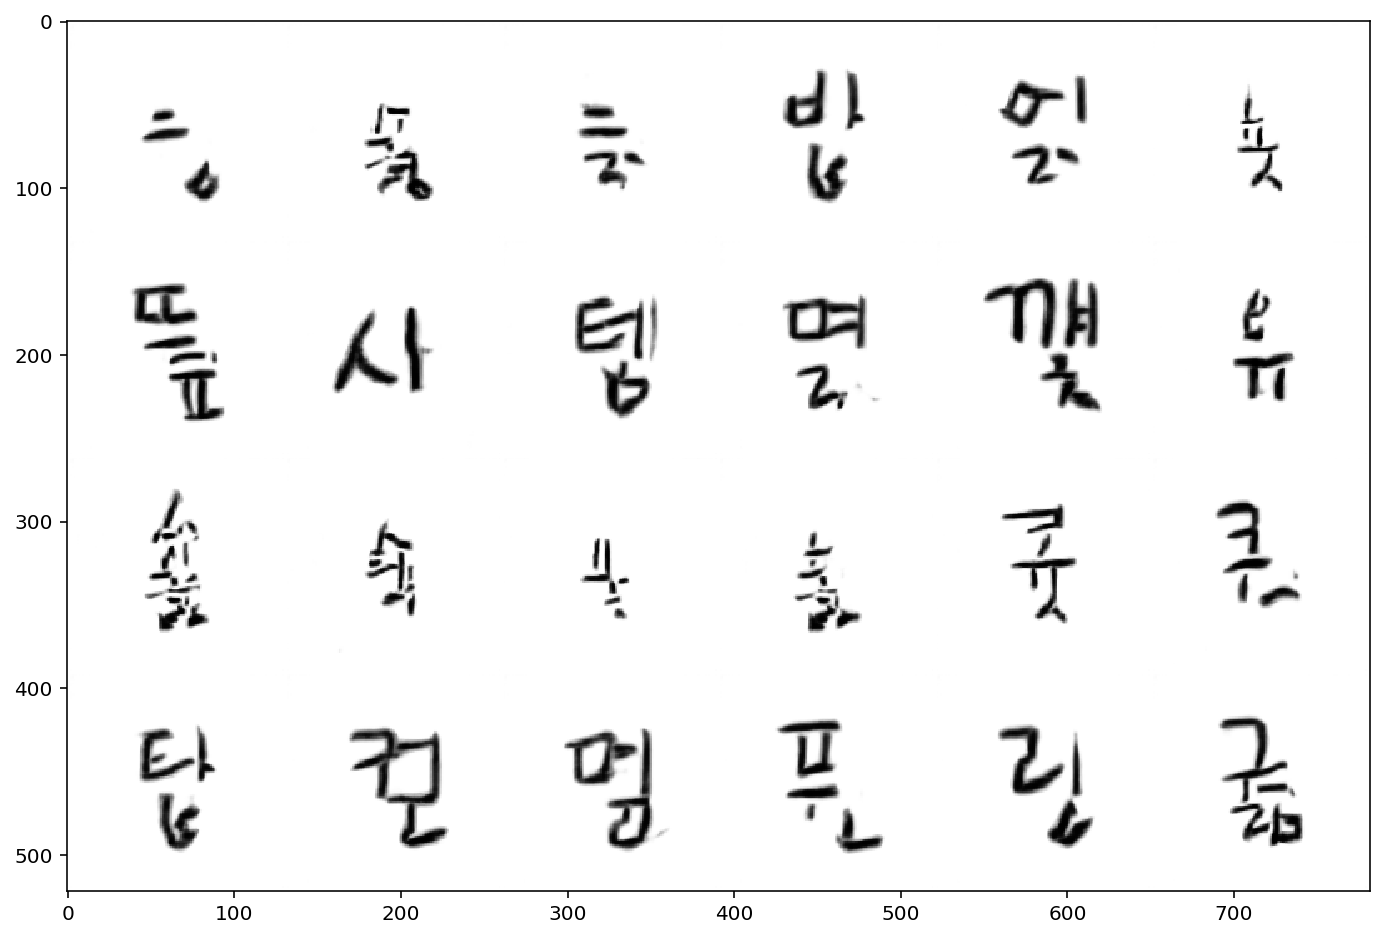

In [55]:
file = filenames[-1]
a = Image.open(file).convert('L')
plt.figure(figsize=(12, 8))
plt.imshow(a, cmap='gray')
plt.show()

ㅋㅋㅋㅋ처참..ㅎ

---

# Validation
- 안 본 글자들도 생성해보기

### Model import

In [69]:
from_model_path = os.path.join(root_path, '%s_model_checkpoint/' % user_name)
fixed_dir = './handwritings/fixed_sample'

In [70]:
embeddings = torch.load(os.path.join(fixed_dir, 'EMBEDDINGS.pkl'))
embeddings.shape

torch.Size([100, 1, 1, 128])

In [73]:
fixed_label = torch.load(os.path.join(fixed_dir, 'fixed_label_0.pkl'))
fixed_target = torch.load(os.path.join(fixed_dir, 'fixed_target_0.pkl'))
fixed_source = torch.load(os.path.join(fixed_dir, 'fixed_source_0.pkl'))

In [74]:
En = Encoder().cuda()
De = Decoder().cuda()
D = Discriminator(category_num=25).cuda()

restore = ['540-0611-14:13-Encoder.pkl', '540-0611-14:13-Decoder.pkl', '540-0611-14:13-Discriminator.pkl']

encoder_path, decoder_path, discriminator_path = restore
prev_epoch = int(encoder_path.split('-')[0])
En.load_state_dict(torch.load(os.path.join(from_model_path, encoder_path)))
De.load_state_dict(torch.load(os.path.join(from_model_path, decoder_path)))
D.load_state_dict(torch.load(os.path.join(from_model_path, discriminator_path)))
print("%d epoch trained model has restored" % prev_epoch)

540 epoch trained model has restored


### show

In [75]:
fake_target, encoded_source, _ = Generator(fixed_source, En, De, embeddings, \
                                           fixed_label, GPU=GPU, encode_layers=True)

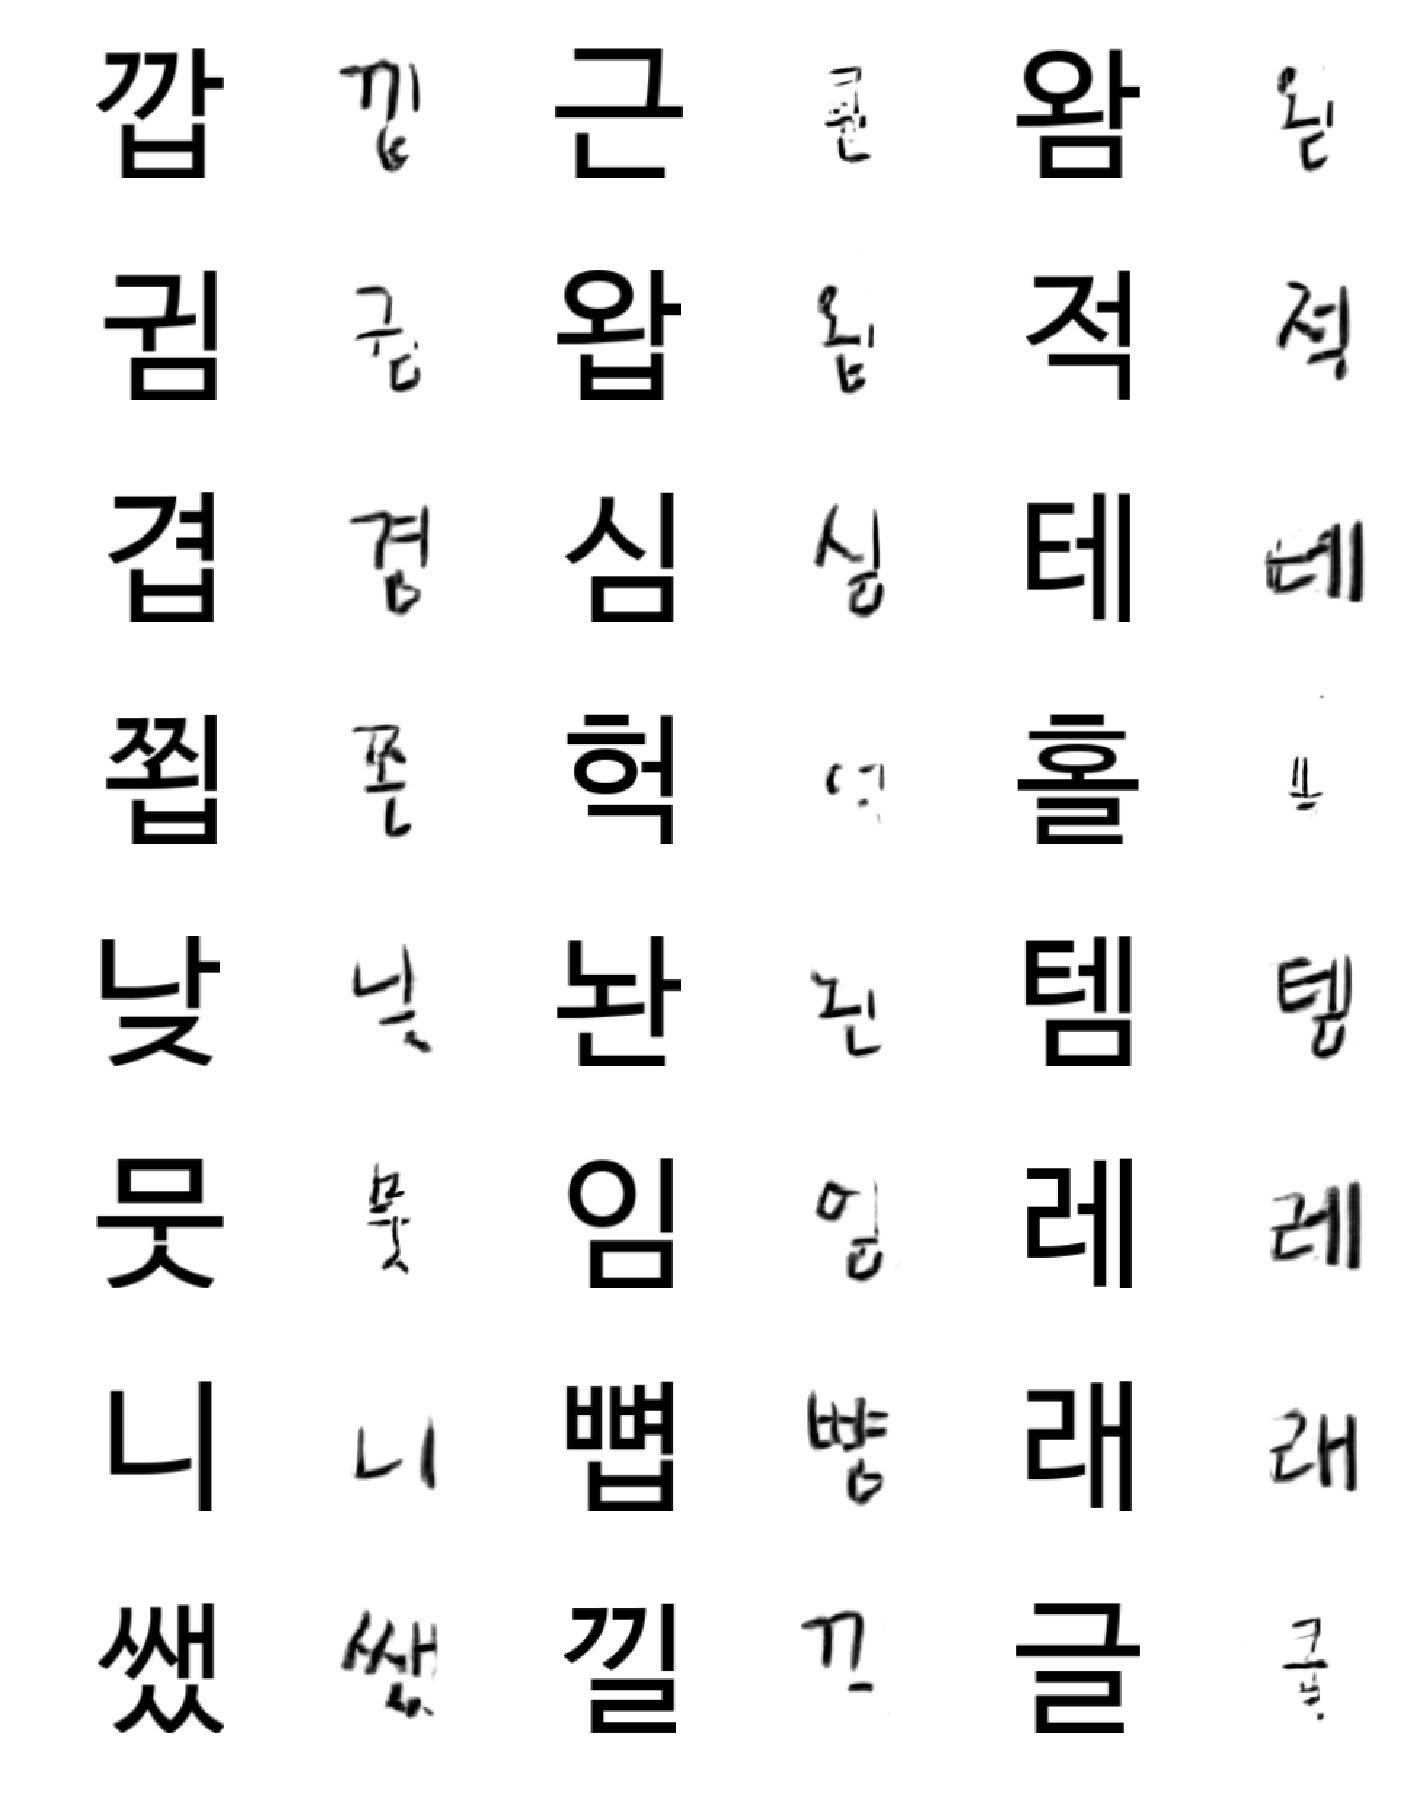

In [81]:
plt.figure(figsize=(12, 16))
for idx, (image_R, image_F) in enumerate(zip(fixed_source, fake_target)):
    plt.subplot(8, 6, 2*idx+1)
    plt.imshow(image_R.cpu().detach().numpy().reshape(128, 128), cmap='gray')
    plt.axis('off')
    
    plt.subplot(8, 6, 2*idx+2)
    plt.imshow(image_F.cpu().detach().numpy().reshape(128, 128), cmap='gray')
    plt.axis('off')
plt.show()

으음......